In [1]:
!pip install tensorboard

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from pathlib import Path
import random
import datetime
import time

from models.ema import WeightEMA
from models.utils import get_model
from data import get_data, show_imgs
from train import *
from test import *
from plot import *

In [3]:
# GPU stuff
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
Tesla V100-SXM2-16GB


In [4]:
%load_ext autoreload
%autoreload 2

## CIFAR-10

### Sym

In [5]:
datapath = "data/"
seed = 123

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using {} device'.format(device))

if device == "cuda":
    if 1 < torch.cuda.device_count():
        print(f"using multiple GPUs: n={torch.cuda.device_count()}")


random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

using cuda device


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
data/cifar10/label_noisy/sym0.4_custom.csv generated

data/cifar10/label_noisy/sym0.4_noise_rules.csv generated

adding inherent noise to cifar10: custom, noise_mode:sym, p:0.4
labels_csv_path:data/cifar10/label_noisy/sym0.4_custom.csv, noise_rules_csv_path:data/cifar10/label_noisy/sym0.4_noise_rules.csv
dataset_name:cifar10, noise_mode:sym, noise_ratio:0.4034
noise_rules
          src                                               dsts    p
0    airplane  ['automobile', 'bird', 'cat', 'deer', 'dog', '...  0.4
1  automobile  ['airplane', 'bird', 'cat', 'deer', 'dog', 'fr...  0.4
2        bird  ['airplane', 'automobile', 'cat', 'deer', 'dog...  0.4
3         cat  ['airplane', 'automobile', 'bird', 'deer', 'do...  0.4
4        deer  ['airplane', 'automobile', 'bird', 'cat', 'do

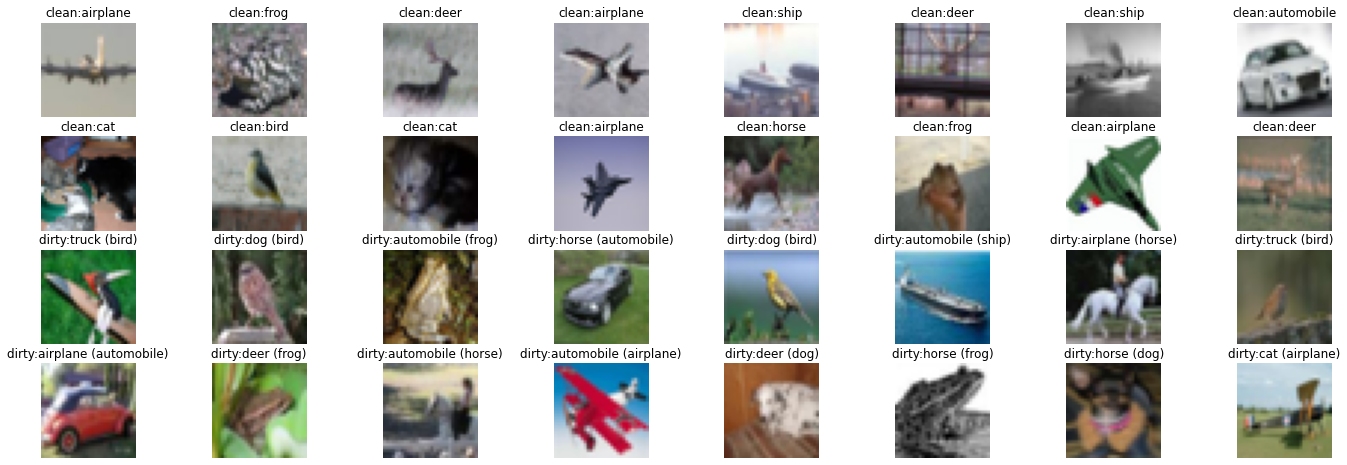

In [6]:
# dataset_names ["cifar10", "cifar100"]
# noise_modes ["sym", "asym", "openset", "dependent"]
# p any probability fro noise to 1 decimal, e.g.: 0.3, 0.6
# custom_noise if True, use custom noise (not by authors in GitHub), else from their GitHub
# make_new_custom_noise if True, make custom noise files

dataset_name = "cifar10"
noise_mode = "sym"
p = 0.4
custom_noise = True
make_new_custom_noise = True

train_dataset, train_dataset_original, indices_noisy, noise_rules, test_dataset = get_data(
    dataset_name=dataset_name,
    datapath=datapath,
    noise_mode=noise_mode, 
    p=p,
    custom_noise=custom_noise,
    make_new_custom_noise=make_new_custom_noise,
    seed=seed)

print(train_dataset)

print(f"dataset_name:{dataset_name}, noise_mode:{noise_mode}, noise_ratio:{indices_noisy.sum() / len(train_dataset.targets):.4f}")
print("noise_rules")
print(noise_rules)
print(indices_noisy)


###############

show_imgs(
    datapath=datapath, 
    dataset_name=dataset_name, 
    train_dataset=train_dataset,
    noise_mode=noise_mode,
    indices_noisy=indices_noisy,
    seed=seed
)

### Questions

- openset: cifar10 and cifar100 have overlapping classes, still in openset noise it is disregarded. what if we accidentally swap a dog in cifar10 for a dog in cifar100?
- openset: swapping transformed images in cifar10 to un-transformed in cifar100?
- normalization parameters?

In [8]:
# possible models:
# 1) baseline: CE - sigma=0, optimizer_ema=None, n_epoch_label_correction_onset=0
# 2) SLN: - 0<sigma n_epoch_label_correction_onset=0
# 3) SLN-MO: - 0<sigma, optimizer_ema!=None, n_epoch_label_correction_onset=0
# 4) SLN-MO-LC: - 0<sigma, optimizer_ema!=None, 0<n_epoch_label_correction_onset(=250 in paper)

dataset_name = "cifar10"
noise_mode = "sym"
p = 0.4
custom_noise = True
make_new_custom_noise = True

train_dataset, _, indices_noisy, noise_rules, test_dataset = get_data(
    dataset_name=dataset_name,
    datapath=datapath,
    noise_mode=noise_mode, 
    p=p,
    custom_noise=custom_noise,
    make_new_custom_noise=make_new_custom_noise,
    seed=seed)

# get number of classes
n_classes = len(list(train_dataset.class_to_idx.keys()))

# run faster for dev
#train_dataset.data, train_dataset.targets = train_dataset.data[:700], train_dataset.targets[:700]
#test_dataset.data, test_dataset.targets = test_dataset.data[:600], test_dataset.targets[:600]

# make targets one-hot (easier to handle in lc and sln), targets_one_hot used in lc
targets = train_dataset.targets
targets_one_hot, train_dataset.targets = np.eye(n_classes)[targets], np.eye(n_classes)[targets]
targets_test = test_dataset.targets
test_dataset.targets = np.eye(n_classes)[targets_test]

# load data
batch_size = 128
# train_dataloader is modified if lc is used
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# train_eval_dataloader is never modified, and is used to compute the loss weights for lc
train_eval_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_dataloader is never modified (test dataset is not onehot yet?)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# models and opts
model_name = "wrn-28-2"
model = get_model(model_name=model_name, n_classes=n_classes, device=device)

# if multi gpu
if device == "cuda":
    if 1 < torch.cuda.device_count():
        model = torch.nn.DataParallel(model)
model.to(device)
#print(model)

lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

#model_ema = get_model(model_name=model_name, n_classes=n_classes, device=device)
model_ema = None

if model_ema:
    # no grads for model_ema
    for param in model_ema.parameters():
        param.detach_()

    # if multi gpu
    if device == "cuda":
        if 1 < torch.cuda.device_count():
            model_ema = torch.nn.DataParallel(model_ema)
    
    model_ema.to(device)
    
    optimizer_ema = WeightEMA(model, model_ema, alpha=0.999)
else:
    optimizer_ema = None

#print(optimizer)

# exp hyperparams
n_epochs = 300
sigma = 0.0
n_epoch_label_correction_onset = 400

# logging and tensorboard stuff
datetime_now = datetime.datetime.now()
exp_id = f"exp_{datetime_now}"
writer = SummaryWriter(f"runs/{exp_id}/")

# save lossess and accuracies in lists
loss_epochs = []
loss_noisy_epochs = []
loss_clean_epochs = []
accuracy_epochs = []
loss_test_epochs = []
accuracy_test_epochs = []

ce_cond = sigma == 0 and model_ema is None and n_epochs < n_epoch_label_correction_onset
sln_cond = 0 < sigma and model_ema is None and n_epochs < n_epoch_label_correction_onset
sln_mo_cond = 0 < sigma and model_ema and n_epochs < n_epoch_label_correction_onset
sln_mo_lc_cond = 0 < sigma and model_ema and n_epoch_label_correction_onset < n_epochs
assert ce_cond or sln_cond or sln_mo_cond or sln_mo_lc_cond
print(f"starting training of model: {'ce' if ce_cond else 'sln' if sln_cond else 'sln_mo' if sln_mo_cond else 'sln_mo_lc' if sln_mo_lc_cond else None}")
print(f"exp_id: {exp_id}")

# n_epoch starts from zero, so always adding one for logging and lc onset
for n_epoch in range(1, n_epochs+1):
    # label-correction
    # if SLN-MO-LC model
    if model_ema and n_epoch_label_correction_onset <= n_epoch:
        print(f"lc in n_epoch={n_epoch}")
        # keep targets one hot through lc
        losses, softmaxes = \
            get_lc_params(model_ema=model_ema, train_eval_dataloader=train_eval_dataloader, device=device)
        # normalize to [0.0, 1.0]
        weights = torch.reshape((losses - torch.min(losses)) / (torch.max(losses) - torch.min(losses)), (len(train_dataloader.dataset), 1))
        preds_one_hot = torch.nn.functional.one_hot(softmaxes.argmax(dim=1)).type(torch.FloatTensor)
        # do lc and reload training data (targets_one_hot fixed variable from above)
        targets_one_hot_lc = weights*targets_one_hot + (1-weights)*preds_one_hot
        train_dataset.targets = targets_one_hot_lc
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    loss_epoch, accuracy_epoch, loss_noisy_epoch, loss_clean_epoch = train_loop(
        model=model, 
        device=device,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        optimizer_ema=optimizer_ema,
        sigma=sigma,
        n_classes=n_classes,
        n_epoch=n_epoch,
        n_epochs=n_epochs, 
        indices_noisy=indices_noisy
    )
    
    #writer.add_scalar("loss/train", loss_epoch, n_epoch)
    #writer.add_scalar("loss/train_noisy", loss_noisy_epoch, n_epoch)
    #writer.add_scalar("loss/train_clean", loss_clean_epoch, n_epoch)
    writer.add_scalar("accuracy/train", accuracy_epoch, n_epoch)
    
    writer.add_scalars('loss/train', {'all': loss_epoch,
                                      'noisy': loss_noisy_epoch,
                                      'clean': loss_clean_epoch}, n_epoch)
    
    loss_epochs.append(loss_epoch)
    loss_noisy_epochs.append(loss_noisy_epoch)
    loss_clean_epochs.append(loss_clean_epoch)
    accuracy_epochs.append(accuracy_epoch)
    
    if optimizer_ema:
        loss_test, accuracy_test = test_loop(
            model=model_ema, 
            device=device,
            test_dataloader=test_dataloader,
            n_epoch=n_epoch,
            n_epochs=n_epochs)
        
        writer.add_scalar("loss/test", loss_test, n_epoch)
        writer.add_scalar("accuracy/test", accuracy_test, n_epoch)
        loss_test_epochs.append(loss_test)
        accuracy_test_epochs.append(accuracy_test)
    
        print(f"epoch={n_epoch}/{n_epochs}, loss_epoch={loss_epoch:.4f}, acc_epoch={accuracy_epoch:.4f}, "
              f"loss_test={loss_test:.4f}, accuracy_test={accuracy_test:.4f}")
    else:
        loss_test, accuracy_test = test_loop(
            model=model, 
            device=device,
            test_dataloader=test_dataloader,
            n_epoch=n_epoch,
            n_epochs=n_epochs)
        
        writer.add_scalar("loss/test", loss_test, n_epoch)
        writer.add_scalar("accuracy/test", accuracy_test, n_epoch)
        loss_test_epochs.append(loss_test)
        accuracy_test_epochs.append(accuracy_test)
    
        print(f"epoch={n_epoch}/{n_epochs}, loss_epoch={loss_epoch:.4f}, acc_epoch={accuracy_epoch:.4f}, "
              f"loss_test={loss_test:.4f}, accuracy_test={accuracy_test:.4f}")
    
# Call flush() method to make sure that all pending events have been written to disk.
writer.flush()

# Saving
model_save_path = Path(f"saved_models/{exp_id}/")
model_save_path.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_save_path / "model.pth")
if model_ema:
    torch.save(model_ema.state_dict(), model_save_path / "model_ema.pth")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
data/cifar10/label_noisy/sym0.4_custom.csv generated

data/cifar10/label_noisy/sym0.4_noise_rules.csv generated

adding inherent noise to cifar10: custom, noise_mode:sym, p:0.4
labels_csv_path:data/cifar10/label_noisy/sym0.4_custom.csv, noise_rules_csv_path:data/cifar10/label_noisy/sym0.4_noise_rules.csv
| Wide-Resnet 28x2
starting training of model: ce
exp_id: exp_2021-11-25 20:04:19.617335


epoch=1/300, batch=61/391, loss_batch=2.2570, acc_batch=0.1484:  16%|█▌        | 61/391 [00:02<00:14, 23.09it/s]


KeyboardInterrupt: 

In [12]:
dataset_name = "cifar10"
noise_mode = "sym"
p = 0.4
custom_noise = False
make_new_custom_noise = False

train_dataset, train_dataset_original, indices_noisy, noise_rules, test_dataset = get_data(
    dataset_name=dataset_name,
    datapath=datapath,
    noise_mode=noise_mode, 
    p=p,
    custom_noise=custom_noise,
    make_new_custom_noise=make_new_custom_noise)

# get number of classes
n_classes = len(list(train_dataset.class_to_idx.keys()))

# run faster for dev
#train_dataset.data, train_dataset.targets = train_dataset.data[:700], train_dataset.targets[:700]
#test_dataset.data, test_dataset.targets = test_dataset.data[:600], test_dataset.targets[:600]

# make targets one-hot (easier to handle in lc and sln), targets_one_hot used in lc
targets = train_dataset.targets
targets_one_hot, train_dataset.targets = np.eye(n_classes)[targets], np.eye(n_classes)[targets]
targets_test = test_dataset.targets
test_dataset.targets = np.eye(n_classes)[targets_test]

# load data
batch_size = 128
# train_dataloader is modified if lc is used
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# fully clean, for viz only
train_original_dataloader = torch.utils.data.DataLoader(train_dataset_original, batch_size=batch_size, shuffle=True, num_workers=2)
# train_eval_dataloader is never modified, and is used to compute the loss weights for lc
train_eval_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_dataloader is never modified (test dataset is not onehot yet?)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# models and opts
model_name = "wrn-28-2"
model = get_model(model_name=model_name, n_classes=n_classes, device=device)

# if multi gpu
if device == "cuda":
    if 1 < torch.cuda.device_count():
        model = torch.nn.DataParallel(model)
    model.to(device)
    
exp_id = "exp_2021-11-25 16:46:29.066838"
model_load_path = Path(f"saved_models/{exp_id}/model_ema.pth")
model.load_state_dict(torch.load(model_load_path))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
adding inherent noise to cifar10: from paper, noise_mode:sym, p:0.4
labels_csv_path:data/cifar10/label_noisy/sym0.4.csv, noise_rules_csv_path:data/cifar10/label_noisy/sym0.4_noise_rules.csv
| Wide-Resnet 28x2


<All keys matched successfully>

In [ ]:
loss, accuracy, losses, softmaxes, predictions = test(model=model, device=device, dataloader=train_eval_dataloader)

	eval set: batch=208/391, loss_batch=1.8529, acc_batch=0.4844:  52%|█████▏    | 204/391 [00:05<00:04, 40.51it/s]

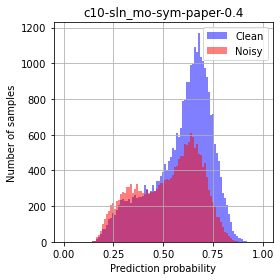

In [10]:
exp_id = "exp_2021-11-25 16:46:29.066838"
viz_save_path = Path(f"assets/{exp_id}")
title = "c10-sln_mo-sym-paper-0.4"

plot_prediction_probabilities(softmaxes=softmaxes, indices_noisy=indices_noisy, title=title, viz_save_path=viz_save_path)

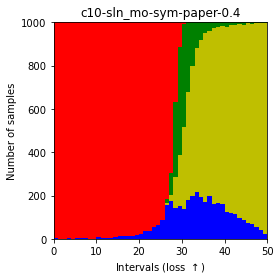

In [11]:
exp_id = "exp_2021-11-25 16:46:29.066838"
viz_save_path = Path(f"assets/{exp_id}")
title = "c10-sln_mo-sym-paper-0.4"

plot_sample_dissection(
    train_eval_dataloader=train_eval_dataloader, 
    train_original_dataloader=train_original_dataloader, 
    predictions=predictions, 
    losses=losses,
    indices_noisy=indices_noisy,
    title=title,
    viz_save_path=viz_save_path
)